<a href="https://colab.research.google.com/github/myoshimu/tfp/blob/master/tfp.sts_ga360.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 構造的時系列モデル(STS)
TensorFlow Probability（TFP）は現在、構造時系列モデルを使ったフィッティングや予測を標準でサポートしています。変分推論（VI）やハミルトニアン・モンテカルロ法（HMC）を使ったモデル パラメーターのベイズ推論などがサポートされており、点推定と不確かさの推定の両方を計算できます。TensorFlow を使って構築されているので、これらの手法はそのままでもベクトル ハードウェア（GPU や TPU）のメリットを活用でき、多くの時系列を効率的かつ並列に処理したり、ディープ ニューラル ネットワークと統合したりできます。

このノートブックでは、構造的な時系列の動きを見るために、Google Analytics の EC サイト月次訪問データを使用して時系列分析してみます。


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.sandbox.google.com/github/myoshimu/tfp/blob/master/tfp.sts_ga360.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/myoshimu/tfp/blob/master/tfp.sts_ga360.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### import modules

In [0]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

import collections

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

### plot 用関数定義

In [0]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast

  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2, label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, 
                  color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

### BQ データを参照する場合は以下を実行

In [48]:
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()
#@title プロジェクト変数の設定 { run: "auto", display-mode: "form" }
project_id = '' #@param {type:"string"}
#dataset_name = "cycle" #@param {type:"string"}
#eval_name = model_name + "_eval"
client = bigquery.Client(project=project_id)

KeyboardInterrupt: ignored

In [0]:
#GA360時系列データ取得
query = """
SELECT
date,
SUM(totals.visits) visits,
SUM(totals.pageviews) pageviews,
SUM(totals.transactions) transactions,
SUM(totals.transactionRevenue)/1000000 revenue
FROM `bigquery-public-data.google_analytics_sample.*`
GROUP BY date
ORDER BY date asc
"""
df = client.query(query).to_dataframe()
df.head()

### csvを参照する場合

In [49]:
df = pd.read_csv("https://raw.githubusercontent.com/myoshimu/tfp/master/ga360_sessions.csv", index_col=0)
df.index = pd.to_datetime(df.index, format='%Y%m%d')
df.head()

,visits,pageviews,transactions,revenue
date,,,,
2016-08-01,1711,9843,34.0,6116.06
2016-08-02,2140,11784,18.0,1361.19
2016-08-03,2890,13724,NaN,NaN
2016-08-04,3161,13326,17.0,1182.89
2016-08-05,2702,13585,42.0,5594.26


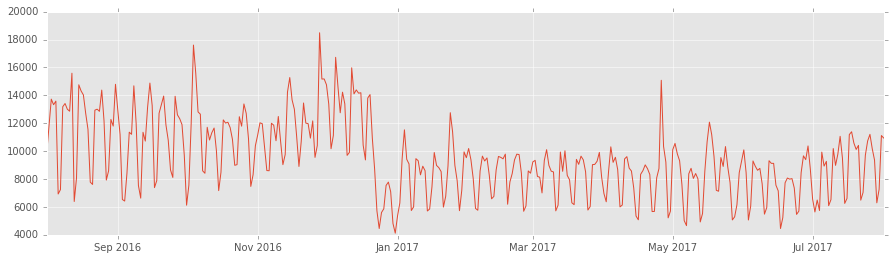

In [50]:
plt.style.use("ggplot")
plt.figure(figsize = (15, 4))

plt.plot(df.index, df.pageviews)
plt.show()

## ローカル線系トレンドモデル
### Model and Fitting
ローカル線形トレンド＋一週間(7日)ごとの季節的影響を加えてモデル化してみます。


In [0]:
#各種初期設定

num_forecast_steps =30 # 一ヶ月分予測
views_by_month = np.array(df["pageviews"], dtype=np.float64)
training_data = views_by_month[:-num_forecast_steps]
dates=np.array(df.index,dtype="datetime64[D]")
#dates=df.index
loc = mdates.MonthLocator()  # matplotlib.datesで時系列データのグラフの軸目盛の設定（3年ごと）
fmt = mdates.DateFormatter('%Y%m') # 年だけ表示

In [0]:
def build_model(observed_time_series):
  trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  seasonal = tfp.sts.Seasonal(
      num_seasons=7, observed_time_series=observed_time_series)
  model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
  return model

変分推論(variational inference：未知パラメータをの平均をとる方法)を使用してモデルをfitし周期性やローカル線形トレンドの推定を行います。 これには、変動損失関数(variational loss function)であるネガティブエビデンス下限値（ELBO=evidence lower bound、確率分布間の距離の最小化を行う際に、許容できる誤差の最小値みたいなもの）を最小限に抑えるためのオプティマイザの実行が含まれます。これはパラメータに対する一連の近似事後分布に適合します。

In [53]:
tf.reset_default_graph()
model = build_model(training_data)

# 事後分布を指定
with tf.variable_scope('sts_elbo', reuse=tf.AUTO_REUSE):
  elbo_loss, variational_posteriors = tfp.sts.build_factored_variational_loss(
      model,
      observed_time_series=training_data)


W0829 01:46:07.722096 139742156109696 linear_operator.py:940] Using (possibly slow) default implementation of to_dense.  Converts by self.matmul(identity).


In [54]:
# 変分推論で変分損失を最小化
num_variational_steps = 201 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

train_vi = tf.train.AdamOptimizer(1).minimize(elbo_loss)
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(num_variational_steps):
    _, elbo_ = sess.run((train_vi, elbo_loss))
    if i % 20 == 0:
      print("step {} -ELBO {}".format(i, elbo_))

  # Draw samples from the variational posterior.
  q_samples_ga360_ = sess.run({k: q.sample(50)
                             for k, q in variational_posteriors.items()})



step 0 -ELBO 41484396.46112578
step 20 -ELBO 647917.5886867357
step 40 -ELBO 461519.37431520707
step 60 -ELBO 418404.9688027867
step 80 -ELBO 503117.0281408798
step 100 -ELBO 412309.34934833867
step 120 -ELBO 438831.2779592653
step 140 -ELBO 430421.47557697125
step 160 -ELBO 273219.6140056111
step 180 -ELBO 120665.87505972436
step 200 -ELBO 301870.56508528214


In [55]:
#ローカル線形トレンドの切片と傾きの誤差（ノイズ）の範囲
print("Inferred parameters:")
for param in model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_ga360_[param.name], axis=0),
                              np.std(q_samples_ga360_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 12.154860197742078 +- 6.455037756250926e-05
LocalLinearTrend/_level_scale: 14.572181056120222 +- 16.78740230832655
LocalLinearTrend/_slope_scale: 11.502391325032807 +- 0.05716771297347717
Seasonal/_drift_scale: 11.193599762514909 +- 7.821835648198574e-05


### 予測と評価

それでは、fitしたモデルを使って予測しましょう。 `tfp.sts.forecast`を呼び出すと、将来の予測分布を表すTensorFlow Distributionインスタンスを返します。
`tfp.sts`予測メソッドは入力として事後標本を必要とし、これにより変分事後分布（variational posterior）から一連のサンプルを引き出せます。

ここでは、トレンドが線形であると仮定した線形トレンドモデルを使用しました。ランダムウォークに従って時間の経過とともに勾配が緩やかに変化するモデルをデータに当てはめると、モデルの仮定に基づいて確率的予測が生成されます。

In [0]:
forecast_dist = tfp.sts.forecast(
    model,
    observed_time_series=training_data,
    parameter_samples=q_samples_ga360_,
    num_steps_forecast=num_forecast_steps)

予測分布の平均と標準偏差によって、各タイムステップの予測が得られます。また、将来おこりうるサンプルを抽出することもできます。

In [0]:
num_samples=100

with tf.Session() as sess:
  forecast_mean, forecast_scale, forecast_samples = sess.run(
      (forecast_dist.mean()[..., 0],
       forecast_dist.stddev()[..., 0],
       forecast_dist.sample(num_samples)[..., 0]))

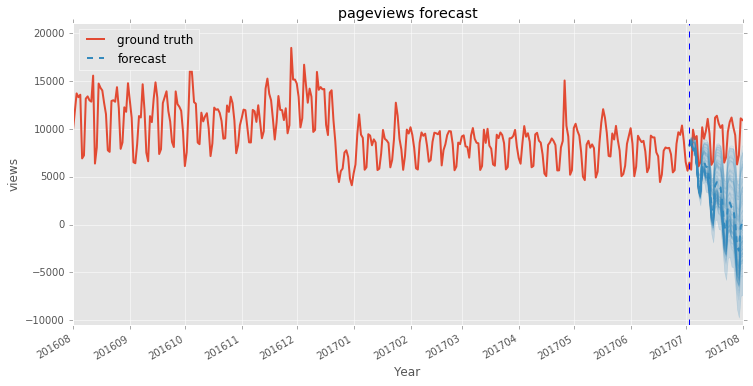

In [58]:
plt.style.use("ggplot")
fig, ax = plot_forecast(
    dates, views_by_month,
    forecast_mean, forecast_scale, forecast_samples,
    x_locator=loc,
    x_formatter=fmt,
    title="pageviews forecast")

ax.axvline(dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("views")
ax.set_xlabel("Year")
fig.autofmt_xdate()

実際よりかなり下向きのトレンドになってしまいました、、。はじめにデータを見て気づくべきでしたが、2017年1月に大幅にpageviewが減っているので、全体も下向きトレンドと認識されてしまったようです。ローカル線形トレンドだとこのような極端な変化の影響を受けてしまうので、以下のように1月以降のデータにするか他のモデルを検討したほうが良いかもしれません。

```
# 2017/1/1以降のデータにする
df = df["2017-01-01":]
```



## トレンドのないモデルに変更

1月の大幅な下落から、そもそもローカル線形トレンドが向いてなさそうなので、季節性だけを取り入れたモデルに変更してみます。

In [0]:
num_forecast_steps =30 # 一ヶ月分予測
views_by_month = np.array(df["pageviews"], dtype=np.float64)
training_data = views_by_month[:-num_forecast_steps]
dates=np.array(df.index,dtype="datetime64[D]")

In [0]:
#モデルを季節性だけに変更
def build_model(observed_time_series):
  seasonal = tfp.sts.Seasonal(
      num_seasons=7, observed_time_series=observed_time_series)
  model = sts.Sum([seasonal], observed_time_series=observed_time_series)
  return model

In [61]:
tf.reset_default_graph()
model = build_model(training_data)

# 事後分布を指定
with tf.variable_scope('sts_elbo', reuse=tf.AUTO_REUSE):
  elbo_loss, variational_posteriors = tfp.sts.build_factored_variational_loss(
      model,
      observed_time_series=training_data)


W0829 01:49:29.046036 139742156109696 linear_operator.py:940] Using (possibly slow) default implementation of to_dense.  Converts by self.matmul(identity).


In [62]:
model.parameters

[Parameter(name='observation_noise_scale', prior=<tfp.distributions.LogNormal 'Sum/LogNormal/' batch_shape=[] event_shape=[] dtype=float64>, bijector=<tensorflow_probability.python.bijectors.softplus.Softplus object at 0x7f178abc0f98>),
 Parameter(name='Seasonal/_drift_scale', prior=<tfp.distributions.LogNormal 'Seasonal/LogNormal/' batch_shape=[] event_shape=[] dtype=float64>, bijector=<tensorflow_probability.python.bijectors.softplus.Softplus object at 0x7f1781317550>)]

In [63]:
# 変分推論で変分損失を最小化
num_variational_steps = 201 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

train_vi = tf.train.AdamOptimizer(1).minimize(elbo_loss)
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(num_variational_steps):
    _, elbo_ = sess.run((train_vi, elbo_loss))
    if i % 20 == 0:
      print("step {} -ELBO {}".format(i, elbo_))

  # Draw samples from the variational posterior.
  q_samples_ga360_ = sess.run({k: q.sample(50)
                             for k, q in variational_posteriors.items()})


step 0 -ELBO 797605495.1031349
step 20 -ELBO 11137747.100145802
step 40 -ELBO 7940492.839583685
step 60 -ELBO 7656077.664943987
step 80 -ELBO 5606369.325022197
step 100 -ELBO 6847246.538041666
step 120 -ELBO 6318433.19124223
step 140 -ELBO 5824178.852007789
step 160 -ELBO 4410414.96581719
step 180 -ELBO 3657397.8915492813
step 200 -ELBO 6379507.941400793


In [64]:
#ローカル線形トレンドの切片と傾きの誤差（ノイズ）の範囲
print("Inferred parameters:")
for param in model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_ga360_[param.name], axis=0),
                              np.std(q_samples_ga360_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 11.027378219405819 +- 0.054691280351541964
Seasonal/_drift_scale: 10.291512822925384 +- 8.494851327898546


In [0]:
forecast_dist = tfp.sts.forecast(
    model,
    observed_time_series=training_data,
    parameter_samples=q_samples_ga360_,
    num_steps_forecast=num_forecast_steps)

In [0]:
num_samples=100

with tf.Session() as sess:
  forecast_mean, forecast_scale, forecast_samples = sess.run(
      (forecast_dist.mean()[..., 0],
       forecast_dist.stddev()[..., 0],
       forecast_dist.sample(num_samples)[..., 0]))

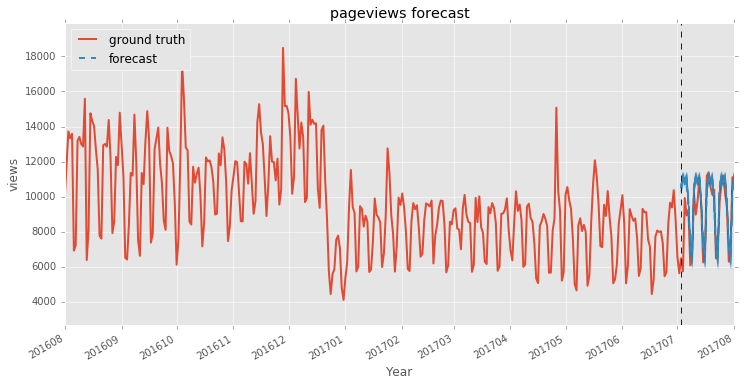

In [67]:
fig, ax = plot_forecast(
    dates, views_by_month,
    forecast_mean, forecast_scale, forecast_samples,
    x_locator=loc,
    x_formatter=fmt,
    title="pageviews forecast")

ax.axvline(dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("views")
ax.set_xlabel("Year")
fig.autofmt_xdate()

先程よりは予測と実測が近くなりました。

## 回帰成分を取り入れたモデル
次にもう少し複雑なモデルを試してみましょう。月の季節性と自己回帰(AR)、visitsからpageviewを回帰する要素を追加してみます。

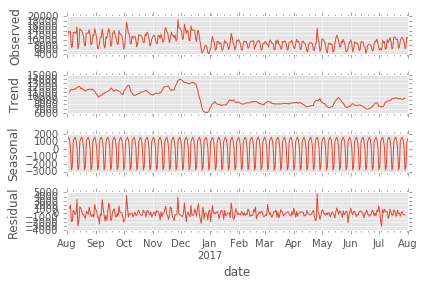

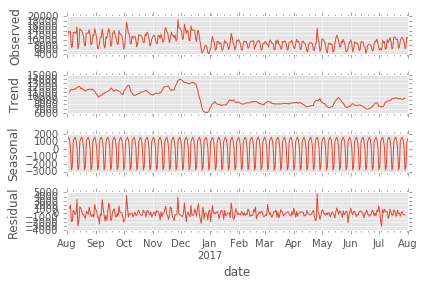

In [68]:
#statsmodelsでトレンドや季節性参照
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.pageviews)
result.plot()

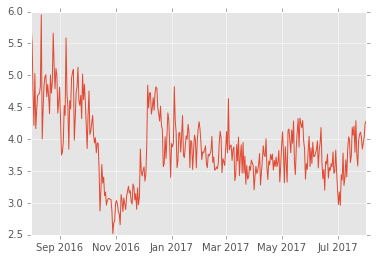

In [69]:
# 訪問あたりのページビュー
plt.plot(df.pageviews / df.visits)
plt.show()

In [0]:
visits = np.array(df["visits"], dtype=np.float64)
pageviews = np.array(df["pageviews"], dtype=np.float64)
pageviews_training_data = pageviews[:-num_forecast_steps]

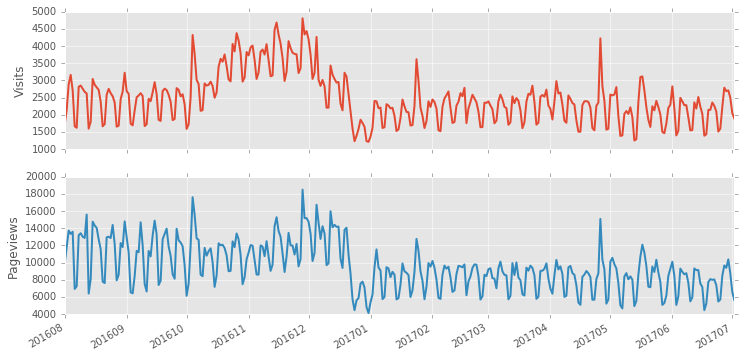

In [71]:
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(dates[:-num_forecast_steps],
        visits[:-num_forecast_steps], lw=2, label="training data")
ax.set_ylabel("Visits")

ax = fig.add_subplot(2, 1, 2)

ax.plot(dates[:-num_forecast_steps],
        pageviews[:-num_forecast_steps], lw=2, label="training data", c=c2)
ax.set_ylabel("Pageviews")
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(fmt)
fig.autofmt_xdate()


In [0]:
def build_model(observed_time_series):
  month_effect = sts.Seasonal(
      num_seasons=12,
      observed_time_series=observed_time_series,
      name='month_effect')
  day_of_week_effect = sts.Seasonal(
      num_seasons=7, num_steps_per_season=24,
      observed_time_series=observed_time_series,
      name='day_of_week_effect')
  visit_effect = sts.LinearRegression(
      design_matrix=tf.reshape(visits - np.mean(visits),
                               (-1, 1)), name='visit_effect')
  #AR(1)成分
  autoregressive = sts.Autoregressive(
      order=1,
      observed_time_series=observed_time_series,
      name='autoregressive')
  model = sts.Sum([month_effect,
                   day_of_week_effect,
                   visit_effect,
                   autoregressive],
                   observed_time_series=observed_time_series)
  return model

In [73]:
tf.reset_default_graph()
regression_model = build_model(pageviews_training_data)

# Build the variational loss function and surrogate posteriors `qs`.
with tf.variable_scope('sts_elbo', reuse=tf.AUTO_REUSE):
  elbo_loss, variational_posteriors = tfp.sts.build_factored_variational_loss(
      regression_model, pageviews_training_data)
train_vi = tf.train.AdamOptimizer(0.1).minimize(elbo_loss)

W0829 01:52:10.209123 139742156109696 linear_operator.py:940] Using (possibly slow) default implementation of to_dense.  Converts by self.matmul(identity).
W0829 01:52:10.309902 139742156109696 linear_operator.py:940] Using (possibly slow) default implementation of to_dense.  Converts by self.matmul(identity).


In [74]:
# 最適化を実行し、事後分布からサンプルを描画
num_variational_steps = 201  # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for i in range(num_variational_steps):
    _, elbo_ = sess.run((train_vi, elbo_loss))
    if i % 20 == 0:
      print("step {} -ELBO {}".format(i, elbo_))

  q_samples_pageviews_ = sess.run({k: q.sample(50)
                                for k, q in variational_posteriors.items()})

step 0 -ELBO 210447465.80212227
step 20 -ELBO 20276953.0301602
step 40 -ELBO 10149346.975254538
step 60 -ELBO 6800180.166752283
step 80 -ELBO 4791504.457876683
step 100 -ELBO 3599577.5500249797
step 120 -ELBO 2919304.1888958155
step 140 -ELBO 2405320.3900326476
step 160 -ELBO 1977957.479134198
step 180 -ELBO 1614365.885803582
step 200 -ELBO 1481813.8832361714


In [75]:
print("Inferred parameters:")
for param in regression_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_pageviews_[param.name], axis=0),
                              np.std(q_samples_pageviews_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 4.716750404243246 +- 0.01013919934103759
month_effect/_drift_scale: 4.6947574339944085 +- 0.005693941166709432
day_of_week_effect/_drift_scale: 2.0187042371924138 +- 0.007966694214732511
visit_effect/_weights: [3.43636571] +- [0.05360953]
autoregressive/_coefficients: [0.93571374] +- [0.00151933]
autoregressive/_level_scale: 5.421636956736858 +- 0.04201912220503822


### 予測と評価

In [0]:
pageviews_forecast_dist = tfp.sts.forecast(
    model=regression_model,
    observed_time_series=pageviews_training_data,
    parameter_samples=q_samples_pageviews_,
    num_steps_forecast=num_forecast_steps)

In [0]:
num_samples=100

with tf.Session() as sess:
  (pageviews_forecast_mean,
   pageviews_forecast_scale,
   pageviews_forecast_samples) = sess.run(
      (pageviews_forecast_dist.mean()[..., 0],
       pageviews_forecast_dist.stddev()[..., 0],
       pageviews_forecast_dist.sample(num_samples)[..., 0]))

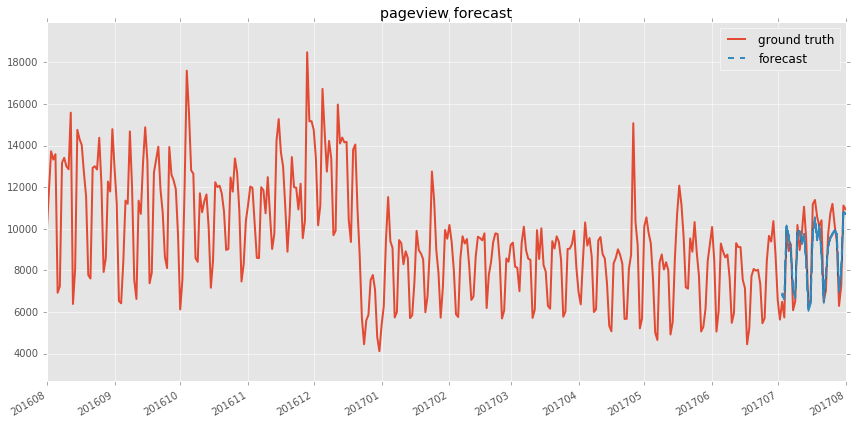

In [78]:
fig, ax = plot_forecast(dates, pageviews,
                        pageviews_forecast_mean,
                        pageviews_forecast_scale,
                        pageviews_forecast_samples,
                        title="pageview forecast",
                        x_locator=loc, x_formatter=fmt)
#ax.set_ylim([0, 10])
fig.tight_layout()